# Qualitative results

### Imports

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from IPython.display import HTML, display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
# from data_mani.visu import *
from prediction.functions import aggregate_prediction_results, gen_strat_positions_and_ret_from_pred, sharpe_ratio_tb, plot_cum_ret
from time import time
init = time()

plt.style.use('bmh')

### Variables

In [2]:
models = ['logit', 'ridge', 'lasso', 'enet', 'random_forest', 'lgb', 'nn3']
models2 = ['LOGIT', 'RIDGE', 'LASSO', 'ENET', 'RF', 'GB', 'NN3']
fs_methods = ['all', 'sfi', 'mdi', 'mda', 'granger', 'huang', 'IAMB', 'MMMB']
fs_methods2 = ['ALL', 'SFI', 'MDI', 'MDA', 'GRANGER', 'HUANG', 'IAMB', 'MMMB']
tickers = ['SPX Index', 'CCMP Index','RTY Index', 'SPX Basic Materials',
           'SPX Communications', 'SPX Consumer Cyclical',
           'SPX Consumer Non cyclical', 'SPX Energy', 'SPX Financial',
           'SPX Industrial', 'SPX Technology', 'SPX Utilities']
benchmark_name = 'return_direction'
metric = "auc"

# Main reference

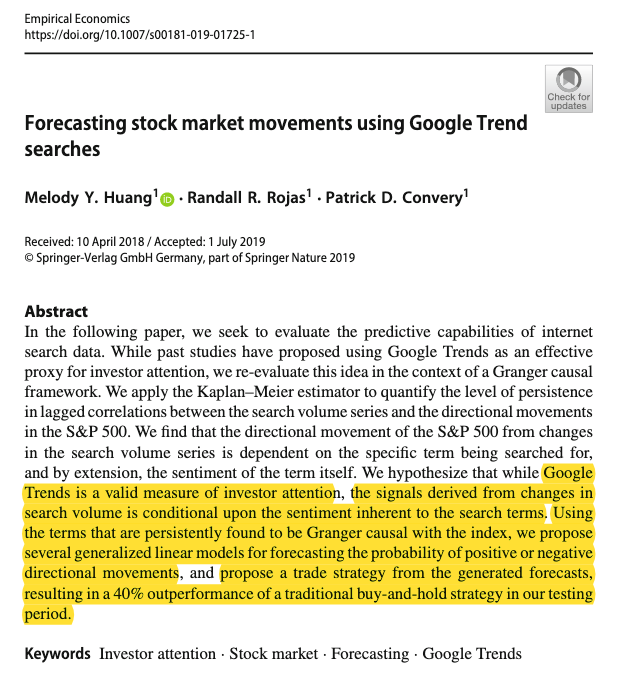

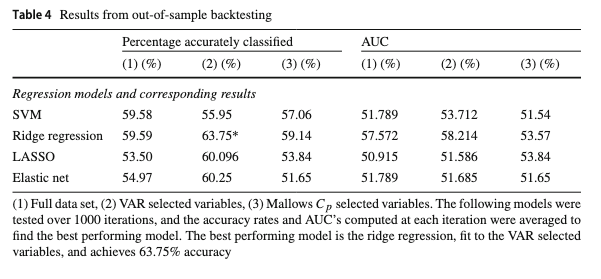

# Our models


## Feature Selection

> 1. All

> 2. Mean decrease impurity (random forest based) - MDI

> 3. Mean decrease accuracy (oos loss of performance; class based) - MDA

> 4. Single feature importance (oos individual feature; reg based) - SFI

> 5. Grenger causality - GRANGER

> 6. Granger causality + Logit - HUANG

> 7. Incremental association Markov boundary - IAMB

> 8. Max-Min Markov boundary - MMMB


## Prediction Models

> 1. Logit

> 2. Ridge regression

> 3. Lasso regression

> 4. Elastic net regression

> 5. Random Forest

> 6. Gradient Boosting

> 7. LSTM neural network (three layer)

## Prediction Setup

> 0. Sample from '2004-01-01' to '2020-12-31'

> 1. Feature selection: '2004-01-01' to '2012-07-03'

> 2. Forecasting: '2012-07-04' to '2020-12-31'

>> a. Random Search

>> b. Predict next year

>> c. Increase sample

# Aggregate prediction results

In [3]:
benchmarks = glob('data/indices/*.csv')
bench_list = []
for b in benchmarks:
    ticker = b.replace('data/indices/', '').replace('.csv', '')
    bench_ret_df = pd.read_csv(b)[3:]
    bench_ret_df.columns = ['date', 'return']
    bench_ret_df = bench_ret_df.melt('date')
    bench_ret_df['model'] = bench_ret_df['ticker'] = ticker
    bench_ret_df['fs'] = 'raw'

    bench_list.append(bench_ret_df)
benchmark_df = pd.concat(bench_list, axis=0)
benchmark_df['value'] = benchmark_df['value'].astype(float)

In [4]:
oos_start_date = '2012-07-03'
oos_end_date = '2020-12-31'

oos_melt_predictions_df, oos_melt_benchmark_df, oos_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                               fs_models=fs_methods,
                                                                                               evaluation_start_date=oos_start_date,
                                                                                               evaluation_end_date=oos_end_date,
                                                                                               ticker_names=tickers,
                                                                                               metric_name=metric,
                                                                                               tag='oos',
                                                                                               benchmark_name=benchmark_name)

/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['model'] = benchmark_df['ticker']
/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['fs'] = 'raw'


In [5]:
is_melt_predictions_df, is_melt_benchmark_df, is_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                            fs_models=fs_methods,
                                                                                            evaluation_start_date='2005-01-03',
                                                                                            evaluation_end_date='2012-07-03',
                                                                                            ticker_names=tickers,
                                                                                            metric_name=metric,
                                                                                            tag='is',
                                                                                            benchmark_name=benchmark_name)

/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['model'] = benchmark_df['ticker']
/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['fs'] = 'raw'


## 1) AUC Analysis

### 1.1) In sample AUC median values

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.488,0.495,0.491,0.496,0.495,0.488,0.501
SFI,0.564,0.565,0.550,0.594,0.520,0.517,0.531
MDI,0.508,0.503,0.510,0.511,0.505,0.496,0.502
MDA,0.504,0.505,0.495,0.506,0.505,0.503,0.505
GRANGER,0.548,0.548,0.553,0.550,0.518,0.514,0.525
HUANG,0.567,0.567,0.567,0.568,0.531,0.530,0.539
IAMB,0.618,0.618,0.618,0.618,0.556,0.547,0.579
MMMB,0.564,0.564,0.564,0.564,0.533,0.532,0.516


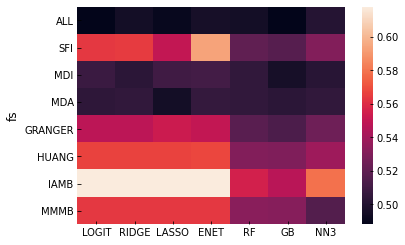

In [6]:
is_auc_df = is_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['isauc'], aggfunc='median')
simple_cols = [c[1] for c in is_auc_df.columns]
is_auc_df.columns = simple_cols
is_auc_df = is_auc_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.1) In sample AUC median values"))
display(HTML(is_auc_df.to_html()))
sns.heatmap(is_auc_df);

In [7]:
print((is_auc_df * 100).reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &  ENET &   RF &   GB &  NN3 \\
\midrule
    ALL &   48.8 &   49.5 &   49.1 &  49.6 & 49.5 & 48.8 & 50.1 \\
    SFI &   56.4 &   56.5 &   55.0 &  59.4 & 52.0 & 51.7 & 53.1 \\
    MDI &   50.8 &   50.3 &   51.0 &  51.1 & 50.5 & 49.6 & 50.2 \\
    MDA &   50.4 &   50.5 &   49.5 &  50.6 & 50.5 & 50.3 & 50.5 \\
GRANGER &   54.8 &   54.8 &   55.3 &  55.0 & 51.8 & 51.4 & 52.5 \\
  HUANG &   56.7 &   56.7 &   56.7 &  56.8 & 53.1 & 53.0 & 53.9 \\
   IAMB &   61.8 &   61.8 &   61.8 &  61.8 & 55.6 & 54.7 & 57.9 \\
   MMMB &   56.4 &   56.4 &   56.4 &  56.4 & 53.3 & 53.2 & 51.6 \\
\bottomrule
\end{tabular}



In [8]:
is_auc_df.mean(axis=1).sort_values()

fs
ALL        0.493429
MDA        0.503286
MDI        0.505000
GRANGER    0.536571
MMMB       0.548143
SFI        0.548714
HUANG      0.552714
IAMB       0.593429
dtype: float64

In [9]:
is_auc_df.mean(axis=0).sort_values()

GB       0.515875
RF       0.520375
NN3      0.524750
LASSO    0.543500
LOGIT    0.545125
RIDGE    0.545625
ENET     0.550875
dtype: float64

### 1.2) Out of sample AUC median values

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.500,0.499,0.501,0.504,0.495,0.501,0.495
SFI,0.508,0.500,0.503,0.504,0.485,0.496,0.500
MDI,0.497,0.501,0.503,0.496,0.492,0.491,0.498
MDA,0.504,0.502,0.503,0.498,0.501,0.496,0.498
GRANGER,0.505,0.505,0.506,0.506,0.495,0.497,0.498
HUANG,0.501,0.501,0.501,0.501,0.496,0.501,0.496
IAMB,0.505,0.505,0.504,0.505,0.501,0.496,0.504
MMMB,0.492,0.492,0.492,0.492,0.491,0.496,0.496


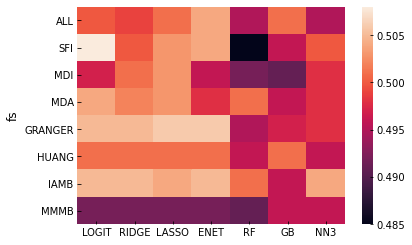

In [10]:
oos_auc_df = oos_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['oosauc'], aggfunc='median')
simple_cols = [c[1] for c in oos_auc_df.columns]
oos_auc_df.columns = simple_cols
oos_auc_df = oos_auc_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.2) Out of sample AUC median values"))
display(HTML(oos_auc_df.to_html()))
sns.heatmap(oos_auc_df);

In [11]:
print((oos_auc_df * 100).reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &  ENET &   RF &   GB &  NN3 \\
\midrule
    ALL &   50.0 &   49.9 &   50.1 &  50.4 & 49.5 & 50.1 & 49.5 \\
    SFI &   50.8 &   50.0 &   50.3 &  50.4 & 48.5 & 49.6 & 50.0 \\
    MDI &   49.7 &   50.1 &   50.3 &  49.6 & 49.2 & 49.1 & 49.8 \\
    MDA &   50.4 &   50.2 &   50.3 &  49.8 & 50.1 & 49.6 & 49.8 \\
GRANGER &   50.5 &   50.5 &   50.6 &  50.6 & 49.5 & 49.7 & 49.8 \\
  HUANG &   50.1 &   50.1 &   50.1 &  50.1 & 49.6 & 50.1 & 49.6 \\
   IAMB &   50.5 &   50.5 &   50.4 &  50.5 & 50.1 & 49.6 & 50.4 \\
   MMMB &   49.2 &   49.2 &   49.2 &  49.2 & 49.1 & 49.6 & 49.6 \\
\bottomrule
\end{tabular}



In [12]:
oos_auc_df.mean(axis=0)

LOGIT    0.501500
RIDGE    0.500625
LASSO    0.501625
ENET     0.500750
RF       0.494500
GB       0.496750
NN3      0.498125
dtype: float64

In [13]:
oos_auc_df.mean(axis=1)

fs
ALL        0.499286
SFI        0.499429
MDI        0.496857
MDA        0.500286
GRANGER    0.501714
HUANG      0.499571
IAMB       0.502857
MMMB       0.493000
dtype: float64

### 1.3) Out of sample AUC distribution across models

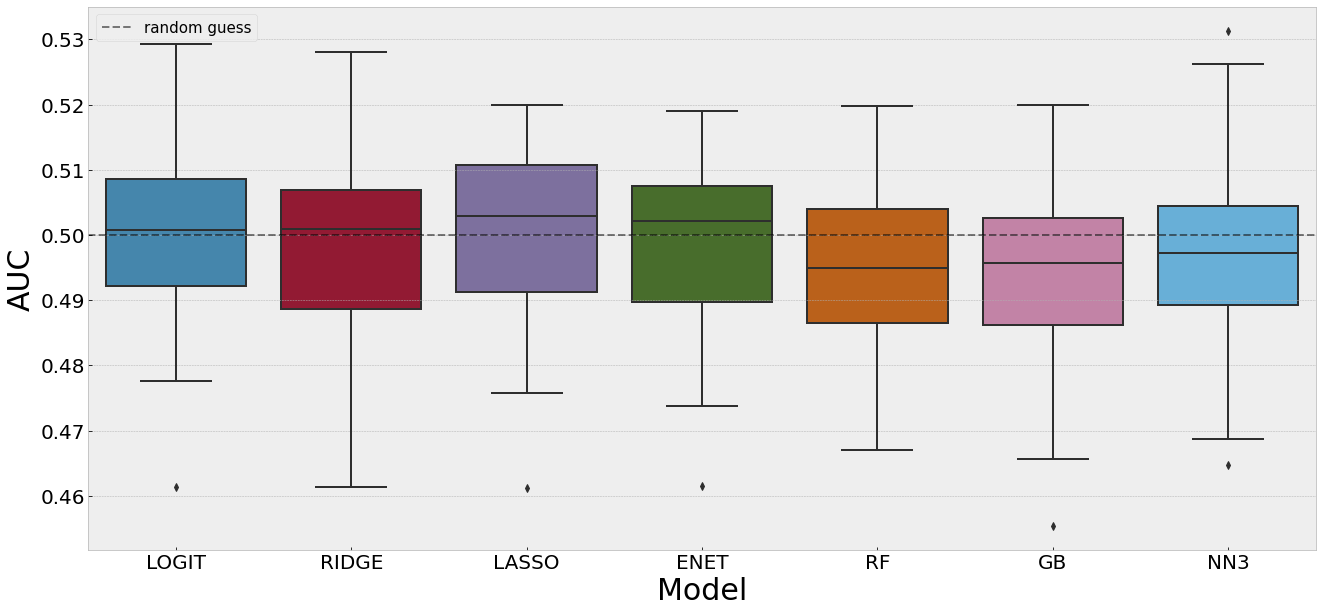

In [14]:
display(Markdown("### 1.3) Out of sample AUC distribution across models"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='oosauc',data=oos_melt_auc_df, ax=ax, order=models2);
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_models_distr.png')

### 1.4) Out of sample AUC distribution across feature selection methods

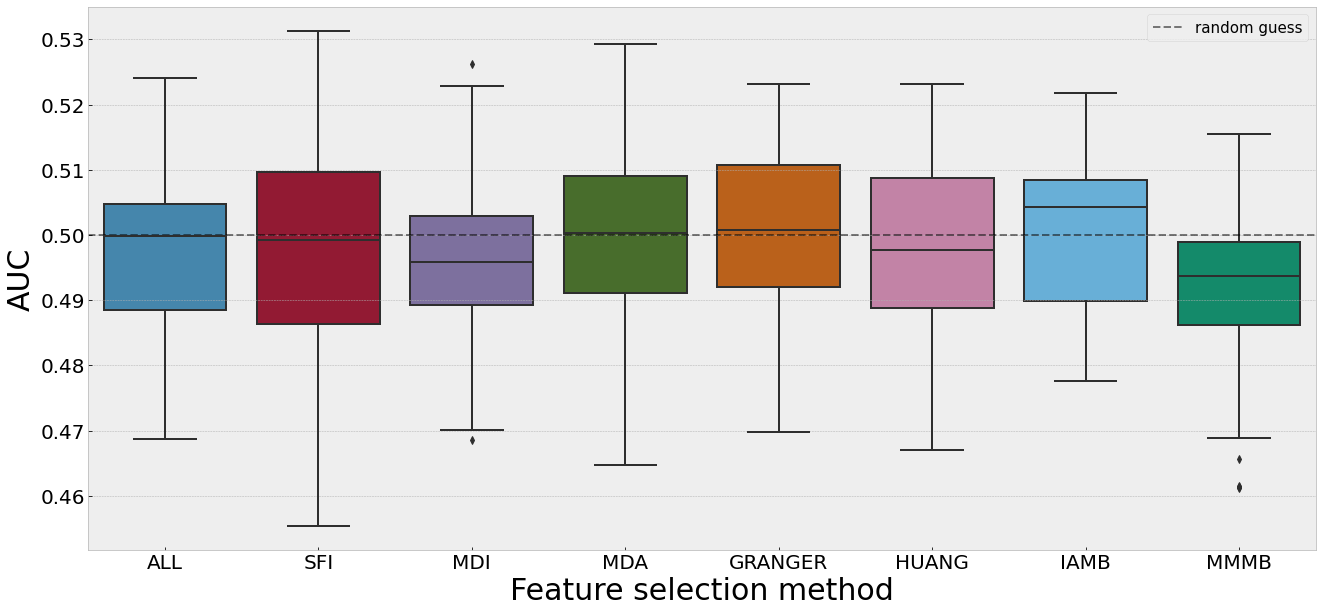

In [15]:
display(Markdown("### 1.4) Out of sample AUC distribution across feature selection methods"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='oosauc',data=oos_melt_auc_df, ax=ax, order=fs_methods2);
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_fs_methods_distr.png')

### 1.5) Out of sample AUC distribution across models (SPX index only)

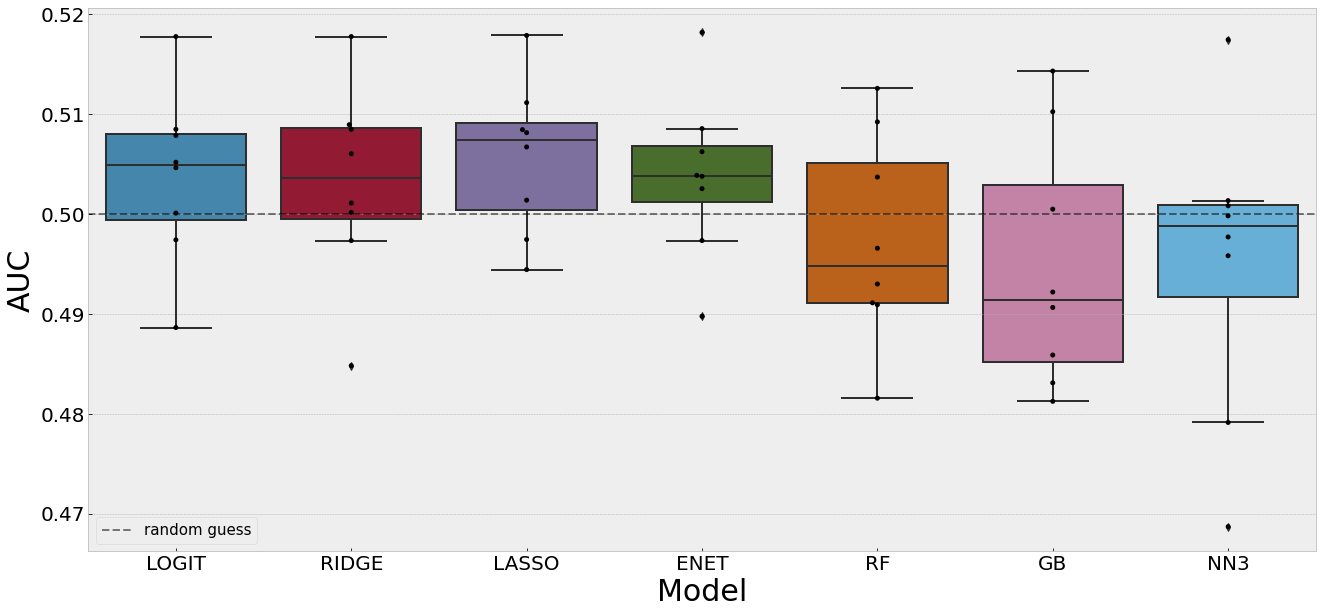

In [16]:
oos_spx_auc_df = oos_melt_auc_df[oos_melt_auc_df["ticker"] == "SPX Index"].reset_index(drop=True)


display(Markdown("### 1.5) Out of sample AUC distribution across models (SPX index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='oosauc',
            data=oos_spx_auc_df, ax=ax, order=models2);
sns.swarmplot(x="model", y='oosauc',
              data=oos_spx_auc_df,ax=ax,
              color="k",order=models2)

ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_models_distr_spx.png')


In [17]:
oos_spx_auc_df.groupby(by=['ticker', 'model'], as_index=True).mean()['oosauc']

ticker     model
SPX Index  ENET     0.503782
           GB       0.494759
           LASSO    0.505702
           LOGIT    0.503759
           NN3      0.495096
           RF       0.497328
           RIDGE    0.503080
Name: oosauc, dtype: float64

### 1.6) Out of sample AUC distribution across feature selection methods (SPX index only)

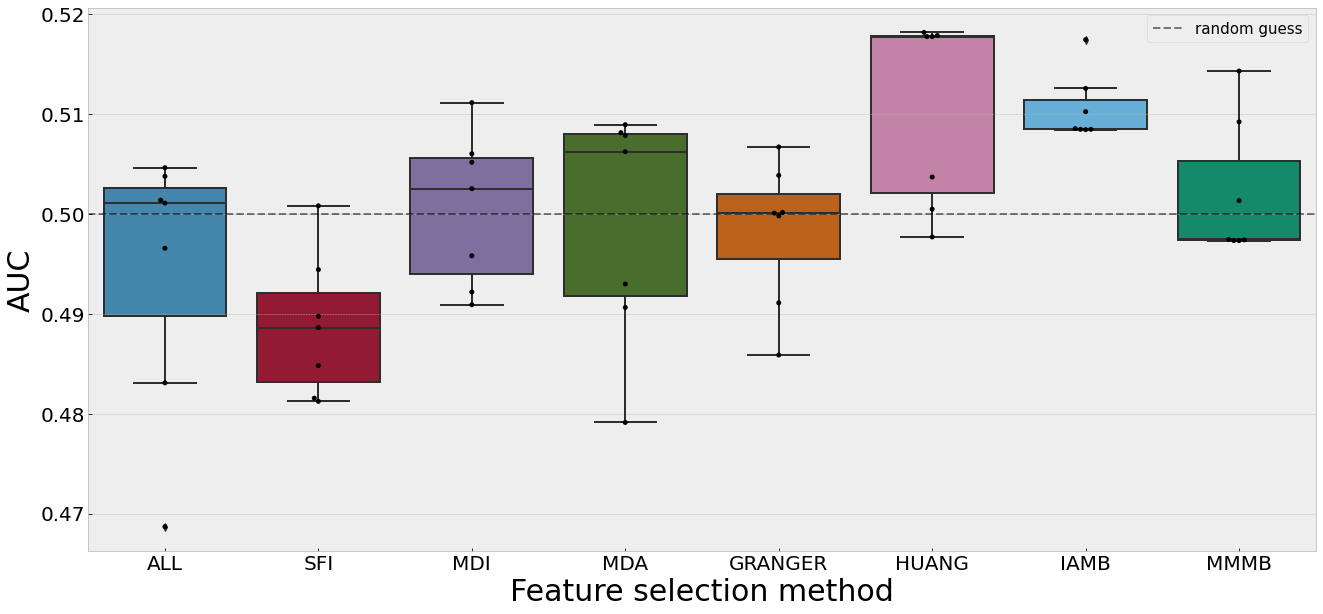

In [18]:
display(Markdown("### 1.6) Out of sample AUC distribution across feature selection methods (SPX index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='oosauc',data=oos_spx_auc_df, ax=ax, order=fs_methods2);
sns.swarmplot(x="fs", y='oosauc',
              data=oos_spx_auc_df,ax=ax,
              color="k",order=fs_methods2)
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_fs_methods_distr_spx.png')

In [19]:
oos_spx_auc_df.groupby(by=['ticker', 'fs'], as_index=True).median()['oosauc']

ticker     fs     
SPX Index  ALL        0.501096
           GRANGER    0.500092
           HUANG      0.517772
           IAMB       0.508553
           MDA        0.506239
           MDI        0.502536
           MMMB       0.497448
           SFI        0.488627
Name: oosauc, dtype: float64

## 2) Sharpe ratio

In [20]:
oos_pred_ret_df, oos_pred_pos_df = gen_strat_positions_and_ret_from_pred(predictions_df=oos_melt_predictions_df,
                                                                         class_threshold=0.5,
                                                                         target_asset_returns=benchmark_df)
ret_all_df = pd.concat([oos_pred_ret_df, benchmark_df], axis=0)
sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs',
                                                  rf=.0)

ret_all_df = pd.concat([oos_pred_ret_df, benchmark_df], axis=0)
sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs',
                                                  rf=.0)

sr_df = sr_rank_df.reset_index()
sr_df_raw = sr_df.loc[sr_df["fs"]=="raw"].reset_index(drop=True)
sr_df = sr_df.loc[sr_df["fs"]!="raw"].reset_index(drop=True)
sr_df_spx = sr_df.loc[sr_df["ticker"]=="SPX Index"].reset_index(drop=True)

# average_sr = np.median([sr_df.groupby(by=['model'], as_index=True).median()['sharpe ratio'].median(), sr_df.groupby(by=['fs'], as_index=True).median()['sharpe ratio'].median()])

# Sanity Check
assert oos_melt_auc_df.shape[0] == sr_df.shape[0]

In [31]:
oos_benchmark_df = benchmark_df.loc[(benchmark_df['date'])>= oos_start_date]
pivot_oos_benchmark_df = oos_benchmark_df.pivot_table(index=['date'], columns=['model'], values=['value'])
pivot_oos_benchmark_df.columns = pivot_oos_benchmark_df.columns.droplevel()

In [42]:
pivot_oos_benchmark_df['Combined portfolio'] = pivot_oos_benchmark_df.mean(axis=1)

In [43]:
sr_benchmark = (pivot_oos_benchmark_df.mean() / pivot_oos_benchmark_df.std() * np.sqrt(252)).reset_index()
sr_benchmark.columns = ['ticker', 'sharpe ratio']

### 2.1) Out of sample Sharpe values median values (average benchmark 0.881)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.143,-0.126,0.030,0.334,0.605,0.129,0.669
SFI,0.064,0.210,0.006,0.155,0.661,0.011,0.638
MDI,0.025,0.070,0.100,0.218,0.713,-0.018,0.657
MDA,0.097,0.081,0.143,0.228,0.714,0.054,0.509
GRANGER,0.396,0.396,0.664,0.480,0.635,0.140,0.688
HUANG,0.716,0.716,0.714,0.684,0.717,0.367,0.708
IAMB,0.172,0.172,0.177,0.160,0.620,0.256,0.503
MMMB,0.616,0.616,0.640,0.625,0.690,0.575,0.641


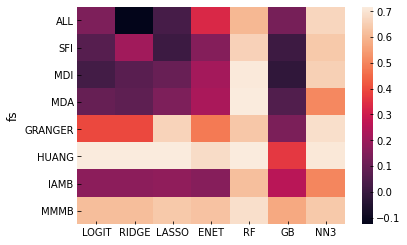

In [50]:
simple_sr_df = sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
simple_cols = [c[1] for c in simple_sr_df.columns]
simple_sr_df.columns = simple_cols
simple_sr_df = simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == 'Combined portfolio']['sharpe ratio'].iloc[0]

display(Markdown("### 2.1) Out of sample Sharpe values median values (average benchmark {:.3f})".format(average_sr)))
display(HTML(simple_sr_df.to_html()))
sns.heatmap(simple_sr_df);

In [21]:
print((simple_sr_df).reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &     GB &   NN3 \\
\midrule
    ALL &  0.143 & -0.126 &  0.030 & 0.334 & 0.605 &  0.129 & 0.669 \\
    SFI &  0.064 &  0.210 &  0.006 & 0.155 & 0.661 &  0.011 & 0.638 \\
    MDI &  0.025 &  0.070 &  0.100 & 0.218 & 0.713 & -0.018 & 0.657 \\
    MDA &  0.097 &  0.081 &  0.143 & 0.228 & 0.714 &  0.054 & 0.509 \\
GRANGER &  0.396 &  0.396 &  0.664 & 0.480 & 0.635 &  0.140 & 0.688 \\
  HUANG &  0.716 &  0.716 &  0.714 & 0.684 & 0.717 &  0.367 & 0.708 \\
   IAMB &  0.172 &  0.172 &  0.177 & 0.160 & 0.620 &  0.256 & 0.503 \\
   MMMB &  0.616 &  0.616 &  0.640 & 0.625 & 0.690 &  0.575 & 0.641 \\
\bottomrule
\end{tabular}



In [51]:
# display(Markdown("### 2.2) Out of sample Sharpe ratio distribution across models"))

# fig, ax = plt.subplots(figsize=(22,10))
# sns.boxplot(x="model", y='sharpe ratio',data=sr_df, ax=ax, order=models2);
# ax.set_ylabel("Sharpe ratio", fontsize=30);
# ax.set_xlabel("Model", fontsize=30);
# ax.axhline(y=average_sr,
#            color='k',
#            linestyle='--',
#            alpha=0.5, label="Average Sharpe ratio");
# ax.tick_params(axis="x", labelsize=20);
# ax.tick_params(axis="y", labelsize=20);
# ax.legend(loc="best",fontsize=15);
# fig.savefig('img/oos_sr_models_distr.png')

In [52]:
# display(Markdown("### 2.3) Out of sample Sharpe ratio distribution across feature selection methods"))

# fig, ax = plt.subplots(figsize=(22,10))
# sns.boxplot(x="fs", y='sharpe ratio',data=sr_df, ax=ax, order=fs_methods2);
# ax.set_ylabel("Sharpe ratio", fontsize=30);
# ax.set_xlabel("Feature selection method", fontsize=30);
# ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
# ax.tick_params(axis="x", labelsize=20);
# ax.tick_params(axis="y", labelsize=20);
# ax.legend(loc="best",fontsize=15);
# fig.savefig('img/oos_sr_fs_methods_distr.png')

### 2.1) Out of sample Sharpe values median values SPX Index (median benchmark 0.914)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.218,-0.084,0.047,0.344,0.571,-0.421,0.581
SFI,-0.163,-0.324,-0.041,-0.037,0.666,-0.348,0.444
MDI,-0.088,-0.023,0.644,0.687,0.741,-0.196,0.643
MDA,0.590,0.637,0.621,0.867,0.678,-0.306,0.386
GRANGER,0.211,0.207,0.433,0.374,0.449,0.148,0.703
HUANG,0.727,0.727,0.724,0.641,0.946,0.360,0.772
IAMB,0.245,0.245,0.245,0.278,0.850,0.332,0.755
MMMB,0.555,0.555,0.616,0.555,0.676,0.621,0.753


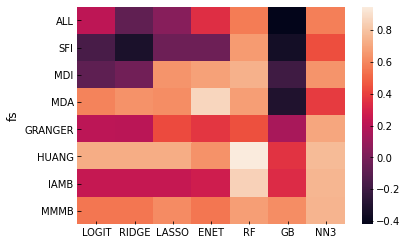

In [53]:
snp_sr_df_raw = sr_df.loc[(sr_df["fs"]=="raw")&(sr_df['ticker']=='SPX Index')].reset_index(drop=True)
snp_sr_df = sr_df.loc[(sr_df["fs"]!="raw")&(sr_df['ticker']=='SPX Index')].reset_index(drop=True)

# snp_average_sr = np.median([snp_sr_df.groupby(by=['model'], as_index=True).median()['sharpe ratio'].median(), snp_sr_df.groupby(by=['fs'], as_index=True).median()['sharpe ratio'].median()])
snp_average_sr = average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == 'SPX Index']['sharpe ratio'].iloc[0]

snp_simple_sr_df = snp_sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
simple_cols = [c[1] for c in snp_simple_sr_df.columns]
snp_simple_sr_df.columns = simple_cols
snp_simple_sr_df = snp_simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Sharpe values median values SPX Index (median benchmark {:.3f})".format(snp_average_sr)))
display(HTML(snp_simple_sr_df.to_html()))
sns.heatmap(snp_simple_sr_df);

In [55]:
for ticker in sr_df['ticker'].unique():
    aux_sr_df_raw = sr_df.loc[(sr_df["fs"]=="raw")&(sr_df['ticker']==ticker)].reset_index(drop=True)
    aux_sr_df = sr_df.loc[(sr_df["fs"]!="raw")&(sr_df['ticker']==ticker)].reset_index(drop=True)

    aux_average_sr = average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == ticker]['sharpe ratio'].iloc[0]

    aux_simple_sr_df = aux_sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
    simple_cols = [c[1] for c in aux_simple_sr_df.columns]
    aux_simple_sr_df.columns = simple_cols
    aux_simple_sr_df = aux_simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 2.1) Out of sample Sharpe values median values " + ticker + " (median benchmark {:.3f})".format(aux_average_sr)))
    display(HTML(aux_simple_sr_df.to_html()))
    # sns.heatmap(aux_simple_sr_df);

### 2.1) Out of sample Sharpe values median values SPX Communications (median benchmark 1.057)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,-0.250,-0.197,0.013,0.323,0.889,0.517,1.017
SFI,0.141,0.200,0.070,0.108,1.390,0.492,0.879
MDI,-0.136,-0.203,-0.667,0.118,0.821,-0.306,1.017
MDA,-0.142,0.040,0.017,0.160,0.989,-0.802,0.865
GRANGER,-0.346,0.125,-0.303,-0.146,1.084,-0.202,0.673
HUANG,0.041,0.038,0.045,0.045,0.964,-0.503,0.824
IAMB,0.172,0.172,0.128,0.153,0.852,0.481,0.487
MMMB,0.702,0.702,0.704,0.697,0.723,0.559,0.606


### 2.1) Out of sample Sharpe values median values SPX Technology (median benchmark 1.250)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,-0.298,-0.246,-0.218,0.244,0.884,0.262,1.106
SFI,-0.013,0.377,-0.296,-0.184,1.118,-0.222,0.759
MDI,0.549,0.313,0.447,0.380,1.040,0.085,1.112
MDA,-0.210,-0.398,-0.303,-0.085,1.270,0.611,0.954
GRANGER,0.393,0.392,0.683,0.510,1.181,0.395,1.003
HUANG,1.083,1.102,1.138,1.001,1.340,0.132,0.955
IAMB,0.172,0.172,0.172,0.151,0.540,0.085,0.938
MMMB,0.801,0.801,0.818,0.801,0.704,0.812,1.220


### 2.1) Out of sample Sharpe values median values SPX Consumer Non cyclical (median benchmark 1.193)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.085,-0.168,-0.476,0.532,1.155,0.076,0.772
SFI,0.281,0.333,0.445,0.409,1.108,0.222,0.759
MDI,0.267,0.314,0.132,0.474,1.154,0.010,1.146
MDA,-0.160,-0.261,0.044,0.297,1.077,0.172,1.180
GRANGER,0.920,0.920,0.917,0.920,1.284,0.243,0.781
HUANG,0.839,0.839,0.841,0.839,1.144,0.037,0.758
IAMB,0.934,0.951,0.932,0.930,0.884,0.938,0.649
MMMB,1.273,1.273,1.253,1.273,1.337,1.278,1.203


### 2.1) Out of sample Sharpe values median values SPX Utilities (median benchmark 0.673)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.459,0.216,0.373,0.080,0.459,0.349,0.366
SFI,0.887,0.675,1.192,0.927,0.781,0.452,0.089
MDI,0.375,0.388,0.639,0.242,0.974,-0.046,0.520
MDA,0.493,0.186,0.610,1.032,0.534,0.069,0.574
GRANGER,0.400,0.400,0.332,0.403,0.625,0.084,0.580
HUANG,0.761,0.761,0.758,0.761,0.735,0.505,0.626
IAMB,0.141,0.113,0.056,0.139,0.623,0.249,0.331
MMMB,0.581,0.581,0.629,0.595,0.434,0.204,0.525


### 2.1) Out of sample Sharpe values median values CCMP Index (median benchmark 1.083)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,-0.450,-0.316,-0.207,0.098,0.809,0.108,1.088
SFI,0.393,0.864,0.236,0.641,0.591,0.529,1.011
MDI,-0.094,-0.143,0.187,0.238,0.685,-0.101,0.486
MDA,-0.492,-0.354,-0.582,0.031,0.405,0.322,1.112
GRANGER,0.908,0.946,0.943,0.923,0.915,0.306,0.907
HUANG,0.975,0.955,1.024,0.979,1.167,0.526,1.103
IAMB,0.444,0.444,0.480,0.444,0.980,0.930,1.027
MMMB,0.651,0.651,0.651,0.654,1.095,0.535,0.864


### 2.1) Out of sample Sharpe values median values SPX Industrial (median benchmark 0.916)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.200,0.207,0.527,0.807,0.451,0.704,0.666
SFI,0.474,0.220,0.049,0.451,0.534,0.163,0.645
MDI,0.086,0.172,0.072,0.056,0.779,0.231,0.330
MDA,0.554,0.656,0.451,0.918,0.790,0.437,0.912
GRANGER,0.789,0.742,0.752,0.785,1.152,0.411,0.955
HUANG,0.794,0.822,0.800,0.793,0.688,0.601,0.853
IAMB,-0.167,-0.167,-0.166,-0.156,0.646,-0.311,0.663
MMMB,0.942,0.942,0.942,0.942,0.872,0.839,0.973


### 2.1) Out of sample Sharpe values median values SPX Index (median benchmark 0.914)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.218,-0.084,0.047,0.344,0.571,-0.421,0.581
SFI,-0.163,-0.324,-0.041,-0.037,0.666,-0.348,0.444
MDI,-0.088,-0.023,0.644,0.687,0.741,-0.196,0.643
MDA,0.590,0.637,0.621,0.867,0.678,-0.306,0.386
GRANGER,0.211,0.207,0.433,0.374,0.449,0.148,0.703
HUANG,0.727,0.727,0.724,0.641,0.946,0.360,0.772
IAMB,0.245,0.245,0.245,0.278,0.850,0.332,0.755
MMMB,0.555,0.555,0.616,0.555,0.676,0.621,0.753


### 2.1) Out of sample Sharpe values median values SPX Financial (median benchmark 0.715)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.279,0.565,0.470,0.728,0.855,-0.403,0.700
SFI,-0.204,-0.169,-0.188,0.314,0.938,0.193,0.083
MDI,0.218,0.162,0.099,0.199,0.540,-0.337,0.242
MDA,0.643,0.716,0.435,0.393,0.818,0.357,0.075
GRANGER,0.927,0.930,0.915,0.919,0.543,0.133,0.598
HUANG,0.483,0.483,0.483,0.483,0.386,-0.273,0.574
IAMB,0.064,0.062,0.064,0.080,0.617,0.505,0.520
MMMB,0.052,0.041,0.182,0.041,0.264,0.591,0.252


### 2.1) Out of sample Sharpe values median values SPX Consumer Cyclical (median benchmark 0.794)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,-0.433,-0.536,-0.493,0.749,0.481,0.134,0.371
SFI,-0.173,-0.218,-0.275,-0.543,0.478,-0.520,0.631
MDI,-0.036,-0.056,-0.069,0.005,0.399,0.379,0.671
MDA,-0.323,-0.172,-0.089,-0.159,0.750,-0.073,0.177
GRANGER,0.896,0.890,0.907,0.885,0.646,0.365,0.774
HUANG,0.705,0.705,0.705,0.727,0.699,0.373,0.624
IAMB,0.047,0.047,0.006,0.042,0.412,0.263,0.191
MMMB,0.757,0.757,0.757,0.765,0.793,0.720,0.575


### 2.1) Out of sample Sharpe values median values RTY Index (median benchmark 0.673)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,-0.122,-0.283,-0.188,-0.191,0.639,0.300,0.673
SFI,-0.210,-0.016,-0.037,-0.044,0.655,-0.701,0.700
MDI,0.289,0.210,0.100,-0.224,0.532,0.188,0.862
MDA,0.145,0.122,0.253,-0.046,0.357,0.038,-0.398
GRANGER,-0.043,0.010,-0.036,0.026,-0.317,0.025,0.400
HUANG,0.287,0.287,0.287,0.302,0.494,0.766,0.610
IAMB,0.168,0.168,0.181,0.168,0.542,-0.384,0.195
MMMB,0.423,0.423,0.423,0.423,0.123,0.188,0.367


### 2.1) Out of sample Sharpe values median values SPX Energy (median benchmark 0.058)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.425,0.301,0.049,0.027,0.058,-0.004,-0.030
SFI,-0.175,-0.287,-0.326,-0.348,-0.304,-0.296,-0.319
MDI,-0.176,-0.129,-0.247,0.277,-0.165,0.090,0.221
MDA,0.797,0.564,0.242,-0.441,0.243,-0.494,-0.079
GRANGER,0.297,0.336,0.644,0.449,-0.485,0.006,0.094
HUANG,0.349,0.349,0.338,0.332,0.064,0.031,0.128
IAMB,0.347,0.347,0.339,0.337,-0.027,-0.078,0.418
MMMB,0.100,0.100,0.100,0.107,-0.106,0.154,-0.137


### 2.1) Out of sample Sharpe values median values SPX Basic Materials (median benchmark 0.663)

,LOGIT,RIDGE,LASSO,ENET,RF,GB,NN3
fs,,,,,,,
ALL,0.265,0.219,0.157,0.365,0.298,0.123,0.657
SFI,0.597,0.631,0.225,0.203,0.180,-0.141,0.072
MDI,-0.467,-0.407,-0.468,-0.547,0.051,-0.463,0.720
MDA,0.050,-0.127,-0.325,0.657,0.137,-0.041,0.443
GRANGER,0.349,0.349,0.394,0.346,0.336,-0.123,0.503
HUANG,0.639,0.639,0.639,0.639,0.545,0.596,0.657
IAMB,0.503,0.503,0.482,0.482,0.379,0.153,0.339
MMMB,0.378,0.378,0.378,0.378,0.150,0.355,0.677


In [26]:
for ticker in sr_df['ticker'].unique():
    aux_sr_df_raw = sr_df.loc[(sr_df["fs"]=="raw")&(sr_df['ticker']==ticker)].reset_index(drop=True)
    aux_sr_df = sr_df.loc[(sr_df["fs"]!="raw")&(sr_df['ticker']==ticker)].reset_index(drop=True)

    aux_average_sr = np.median([aux_sr_df.groupby(by=['model'], as_index=True).median()['sharpe ratio'].median(), aux_sr_df.groupby(by=['fs'], as_index=True).median()['sharpe ratio'].median()])

    aux_simple_sr_df = aux_sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
    simple_cols = [c[1] for c in aux_simple_sr_df.columns]
    aux_simple_sr_df.columns = simple_cols
    aux_simple_sr_df = aux_simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 2.1) Out of sample Sharpe values median values " + ticker + " (median benchmark {:.3f})".format(aux_average_sr)))
    print((aux_simple_sr_df).reset_index().to_latex(index=False))
    # sns.heatmap(aux_simple_sr_df);

### 2.1) Out of sample Sharpe values median values SPX Communications (median benchmark 0.122)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &   ENET &    RF &     GB &   NN3 \\
\midrule
    ALL & -0.250 & -0.197 &  0.013 &  0.323 & 0.889 &  0.517 & 1.017 \\
    SFI &  0.141 &  0.200 &  0.070 &  0.108 & 1.390 &  0.492 & 0.879 \\
    MDI & -0.136 & -0.203 & -0.667 &  0.118 & 0.821 & -0.306 & 1.017 \\
    MDA & -0.142 &  0.040 &  0.017 &  0.160 & 0.989 & -0.802 & 0.865 \\
GRANGER & -0.346 &  0.125 & -0.303 & -0.146 & 1.084 & -0.202 & 0.673 \\
  HUANG &  0.041 &  0.038 &  0.045 &  0.045 & 0.964 & -0.503 & 0.824 \\
   IAMB &  0.172 &  0.172 &  0.128 &  0.153 & 0.852 &  0.481 & 0.487 \\
   MMMB &  0.702 &  0.702 &  0.704 &  0.697 & 0.723 &  0.559 & 0.606 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Technology (median benchmark 0.329)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &   ENET &    RF &     GB &   NN3 \\
\midrule
    ALL & -0.298 & -0.246 & -0.218 &  0.244 & 0.884 &  0.262 & 1.106 \\
    SFI & -0.013 &  0.377 & -0.296 & -0.184 & 1.118 & -0.222 & 0.759 \\
    MDI &  0.549 &  0.313 &  0.447 &  0.380 & 1.040 &  0.085 & 1.112 \\
    MDA & -0.210 & -0.398 & -0.303 & -0.085 & 1.270 &  0.611 & 0.954 \\
GRANGER &  0.393 &  0.392 &  0.683 &  0.510 & 1.181 &  0.395 & 1.003 \\
  HUANG &  1.083 &  1.102 &  1.138 &  1.001 & 1.340 &  0.132 & 0.955 \\
   IAMB &  0.172 &  0.172 &  0.172 &  0.151 & 0.540 &  0.085 & 0.938 \\
   MMMB &  0.801 &  0.801 &  0.818 &  0.801 & 0.704 &  0.812 & 1.220 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Consumer Non cyclical (median benchmark 0.633)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 \\
\midrule
    ALL &  0.085 & -0.168 & -0.476 & 0.532 & 1.155 & 0.076 & 0.772 \\
    SFI &  0.281 &  0.333 &  0.445 & 0.409 & 1.108 & 0.222 & 0.759 \\
    MDI &  0.267 &  0.314 &  0.132 & 0.474 & 1.154 & 0.010 & 1.146 \\
    MDA & -0.160 & -0.261 &  0.044 & 0.297 & 1.077 & 0.172 & 1.180 \\
GRANGER &  0.920 &  0.920 &  0.917 & 0.920 & 1.284 & 0.243 & 0.781 \\
  HUANG &  0.839 &  0.839 &  0.841 & 0.839 & 1.144 & 0.037 & 0.758 \\
   IAMB &  0.934 &  0.951 &  0.932 & 0.930 & 0.884 & 0.938 & 0.649 \\
   MMMB &  1.273 &  1.273 &  1.253 & 1.273 & 1.337 & 1.278 & 1.203 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Utilities (median benchmark 0.483)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &     GB &   NN3 \\
\midrule
    ALL &  0.459 &  0.216 &  0.373 & 0.080 & 0.459 &  0.349 & 0.366 \\
    SFI &  0.887 &  0.675 &  1.192 & 0.927 & 0.781 &  0.452 & 0.089 \\
    MDI &  0.375 &  0.388 &  0.639 & 0.242 & 0.974 & -0.046 & 0.520 \\
    MDA &  0.493 &  0.186 &  0.610 & 1.032 & 0.534 &  0.069 & 0.574 \\
GRANGER &  0.400 &  0.400 &  0.332 & 0.403 & 0.625 &  0.084 & 0.580 \\
  HUANG &  0.761 &  0.761 &  0.758 & 0.761 & 0.735 &  0.505 & 0.626 \\
   IAMB &  0.141 &  0.113 &  0.056 & 0.139 & 0.623 &  0.249 & 0.331 \\
   MMMB &  0.581 &  0.581 &  0.629 & 0.595 & 0.434 &  0.204 & 0.525 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values CCMP Index (median benchmark 0.539)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &     GB &   NN3 \\
\midrule
    ALL & -0.450 & -0.316 & -0.207 & 0.098 & 0.809 &  0.108 & 1.088 \\
    SFI &  0.393 &  0.864 &  0.236 & 0.641 & 0.591 &  0.529 & 1.011 \\
    MDI & -0.094 & -0.143 &  0.187 & 0.238 & 0.685 & -0.101 & 0.486 \\
    MDA & -0.492 & -0.354 & -0.582 & 0.031 & 0.405 &  0.322 & 1.112 \\
GRANGER &  0.908 &  0.946 &  0.943 & 0.923 & 0.915 &  0.306 & 0.907 \\
  HUANG &  0.975 &  0.955 &  1.024 & 0.979 & 1.167 &  0.526 & 1.103 \\
   IAMB &  0.444 &  0.444 &  0.480 & 0.444 & 0.980 &  0.930 & 1.027 \\
   MMMB &  0.651 &  0.651 &  0.651 & 0.654 & 1.095 &  0.535 & 0.864 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Industrial (median benchmark 0.552)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &   ENET &    RF &     GB &   NN3 \\
\midrule
    ALL &  0.200 &  0.207 &  0.527 &  0.807 & 0.451 &  0.704 & 0.666 \\
    SFI &  0.474 &  0.220 &  0.049 &  0.451 & 0.534 &  0.163 & 0.645 \\
    MDI &  0.086 &  0.172 &  0.072 &  0.056 & 0.779 &  0.231 & 0.330 \\
    MDA &  0.554 &  0.656 &  0.451 &  0.918 & 0.790 &  0.437 & 0.912 \\
GRANGER &  0.789 &  0.742 &  0.752 &  0.785 & 1.152 &  0.411 & 0.955 \\
  HUANG &  0.794 &  0.822 &  0.800 &  0.793 & 0.688 &  0.601 & 0.853 \\
   IAMB & -0.167 & -0.167 & -0.166 & -0.156 & 0.646 & -0.311 & 0.663 \\
   MMMB &  0.942 &  0.942 &  0.942 &  0.942 & 0.872 &  0.839 & 0.973 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Index (median benchmark 0.480)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &   ENET &    RF &     GB &   NN3 \\
\midrule
    ALL &  0.218 & -0.084 &  0.047 &  0.344 & 0.571 & -0.421 & 0.581 \\
    SFI & -0.163 & -0.324 & -0.041 & -0.037 & 0.666 & -0.348 & 0.444 \\
    MDI & -0.088 & -0.023 &  0.644 &  0.687 & 0.741 & -0.196 & 0.643 \\
    MDA &  0.590 &  0.637 &  0.621 &  0.867 & 0.678 & -0.306 & 0.386 \\
GRANGER &  0.211 &  0.207 &  0.433 &  0.374 & 0.449 &  0.148 & 0.703 \\
  HUANG &  0.727 &  0.727 &  0.724 &  0.641 & 0.946 &  0.360 & 0.772 \\
   IAMB &  0.245 &  0.245 &  0.245 &  0.278 & 0.850 &  0.332 & 0.755 \\
   MMMB &  0.555 &  0.555 &  0.616 &  0.555 & 0.676 &  0.621 & 0.753 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Financial (median benchmark 0.320)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &     GB &   NN3 \\
\midrule
    ALL &  0.279 &  0.565 &  0.470 & 0.728 & 0.855 & -0.403 & 0.700 \\
    SFI & -0.204 & -0.169 & -0.188 & 0.314 & 0.938 &  0.193 & 0.083 \\
    MDI &  0.218 &  0.162 &  0.099 & 0.199 & 0.540 & -0.337 & 0.242 \\
    MDA &  0.643 &  0.716 &  0.435 & 0.393 & 0.818 &  0.357 & 0.075 \\
GRANGER &  0.927 &  0.930 &  0.915 & 0.919 & 0.543 &  0.133 & 0.598 \\
  HUANG &  0.483 &  0.483 &  0.483 & 0.483 & 0.386 & -0.273 & 0.574 \\
   IAMB &  0.064 &  0.062 &  0.064 & 0.080 & 0.617 &  0.505 & 0.520 \\
   MMMB &  0.052 &  0.041 &  0.182 & 0.041 & 0.264 &  0.591 & 0.252 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Consumer Cyclical (median benchmark 0.202)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &   ENET &    RF &     GB &   NN3 \\
\midrule
    ALL & -0.433 & -0.536 & -0.493 &  0.749 & 0.481 &  0.134 & 0.371 \\
    SFI & -0.173 & -0.218 & -0.275 & -0.543 & 0.478 & -0.520 & 0.631 \\
    MDI & -0.036 & -0.056 & -0.069 &  0.005 & 0.399 &  0.379 & 0.671 \\
    MDA & -0.323 & -0.172 & -0.089 & -0.159 & 0.750 & -0.073 & 0.177 \\
GRANGER &  0.896 &  0.890 &  0.907 &  0.885 & 0.646 &  0.365 & 0.774 \\
  HUANG &  0.705 &  0.705 &  0.705 &  0.727 & 0.699 &  0.373 & 0.624 \\
   IAMB &  0.047 &  0.047 &  0.006 &  0.042 & 0.412 &  0.263 & 0.191 \\
   MMMB &  0.757 &  0.757 &  0.757 &  0.765 & 0.793 &  0.720 & 0.575 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values RTY Index (median benchmark 0.145)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &   ENET &     RF &     GB &    NN3 \\
\midrule
    ALL & -0.122 & -0.283 & -0.188 & -0.191 &  0.639 &  0.300 &  0.673 \\
    SFI & -0.210 & -0.016 & -0.037 & -0.044 &  0.655 & -0.701 &  0.700 \\
    MDI &  0.289 &  0.210 &  0.100 & -0.224 &  0.532 &  0.188 &  0.862 \\
    MDA &  0.145 &  0.122 &  0.253 & -0.046 &  0.357 &  0.038 & -0.398 \\
GRANGER & -0.043 &  0.010 & -0.036 &  0.026 & -0.317 &  0.025 &  0.400 \\
  HUANG &  0.287 &  0.287 &  0.287 &  0.302 &  0.494 &  0.766 &  0.610 \\
   IAMB &  0.168 &  0.168 &  0.181 &  0.168 &  0.542 & -0.384 &  0.195 \\
   MMMB &  0.423 &  0.423 &  0.423 &  0.423 &  0.123 &  0.188 &  0.367 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Energy (median benchmark 0.171)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &   ENET &     RF &     GB &    NN3 \\
\midrule
    ALL &  0.425 &  0.301 &  0.049 &  0.027 &  0.058 & -0.004 & -0.030 \\
    SFI & -0.175 & -0.287 & -0.326 & -0.348 & -0.304 & -0.296 & -0.319 \\
    MDI & -0.176 & -0.129 & -0.247 &  0.277 & -0.165 &  0.090 &  0.221 \\
    MDA &  0.797 &  0.564 &  0.242 & -0.441 &  0.243 & -0.494 & -0.079 \\
GRANGER &  0.297 &  0.336 &  0.644 &  0.449 & -0.485 &  0.006 &  0.094 \\
  HUANG &  0.349 &  0.349 &  0.338 &  0.332 &  0.064 &  0.031 &  0.128 \\
   IAMB &  0.347 &  0.347 &  0.339 &  0.337 & -0.027 & -0.078 &  0.418 \\
   MMMB &  0.100 &  0.100 &  0.100 &  0.107 & -0.106 &  0.154 & -0.137 \\
\bottomrule
\end{tabular}



### 2.1) Out of sample Sharpe values median values SPX Basic Materials (median benchmark 0.335)

\begin{tabular}{lrrrrrrr}
\toprule
     fs &  LOGIT &  RIDGE &  LASSO &   ENET &    RF &     GB &   NN3 \\
\midrule
    ALL &  0.265 &  0.219 &  0.157 &  0.365 & 0.298 &  0.123 & 0.657 \\
    SFI &  0.597 &  0.631 &  0.225 &  0.203 & 0.180 & -0.141 & 0.072 \\
    MDI & -0.467 & -0.407 & -0.468 & -0.547 & 0.051 & -0.463 & 0.720 \\
    MDA &  0.050 & -0.127 & -0.325 &  0.657 & 0.137 & -0.041 & 0.443 \\
GRANGER &  0.349 &  0.349 &  0.394 &  0.346 & 0.336 & -0.123 & 0.503 \\
  HUANG &  0.639 &  0.639 &  0.639 &  0.639 & 0.545 &  0.596 & 0.657 \\
   IAMB &  0.503 &  0.503 &  0.482 &  0.482 & 0.379 &  0.153 & 0.339 \\
   MMMB &  0.378 &  0.378 &  0.378 &  0.378 & 0.150 &  0.355 & 0.677 \\
\bottomrule
\end{tabular}



In [27]:
aux_average_sr

0.3353380110870736

### 2.4) Out of sample Sharpe ratio distribution across models (SPX Index only)

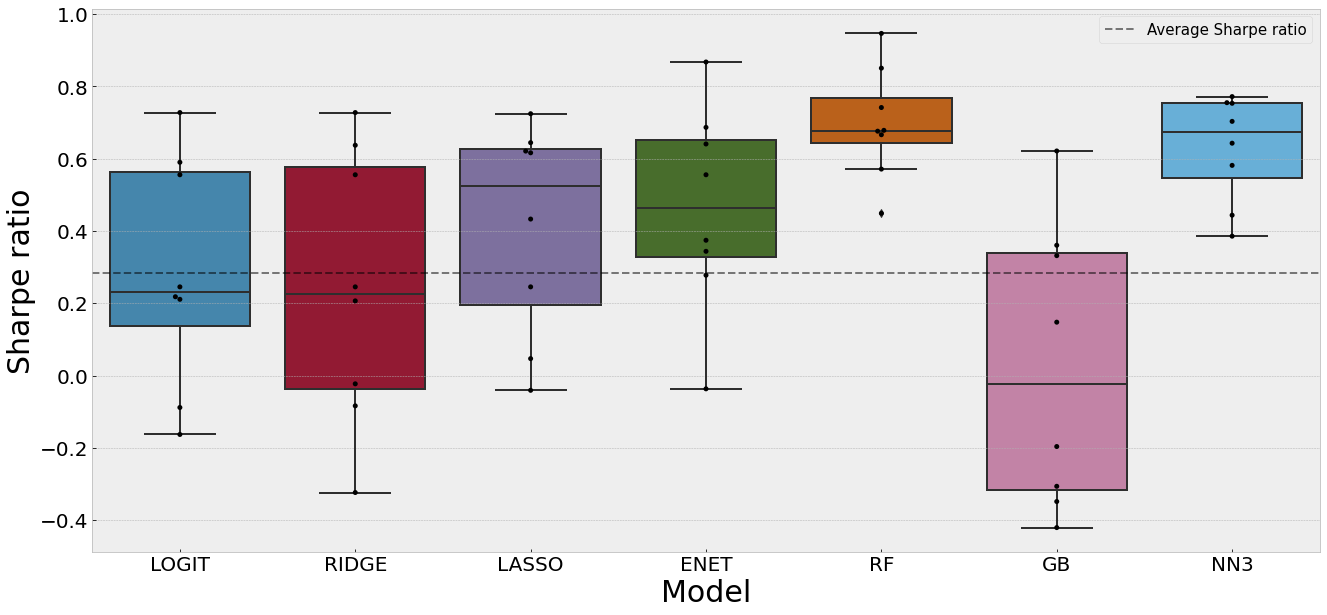

In [28]:
display(Markdown("### 2.4) Out of sample Sharpe ratio distribution across models (SPX Index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='sharpe ratio',data=sr_df_spx, ax=ax, order=models2);
sns.swarmplot(x="model", y='sharpe ratio',
              data=sr_df_spx,ax=ax,
              color="k",order=models2)
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr,
           color='k',
           linestyle='--',
           alpha=0.5, label="Average Sharpe ratio");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_sr_models_distr_spx.png')

### 2.5) Out of sample Sharpe ratio distribution across models (SPX Index only)

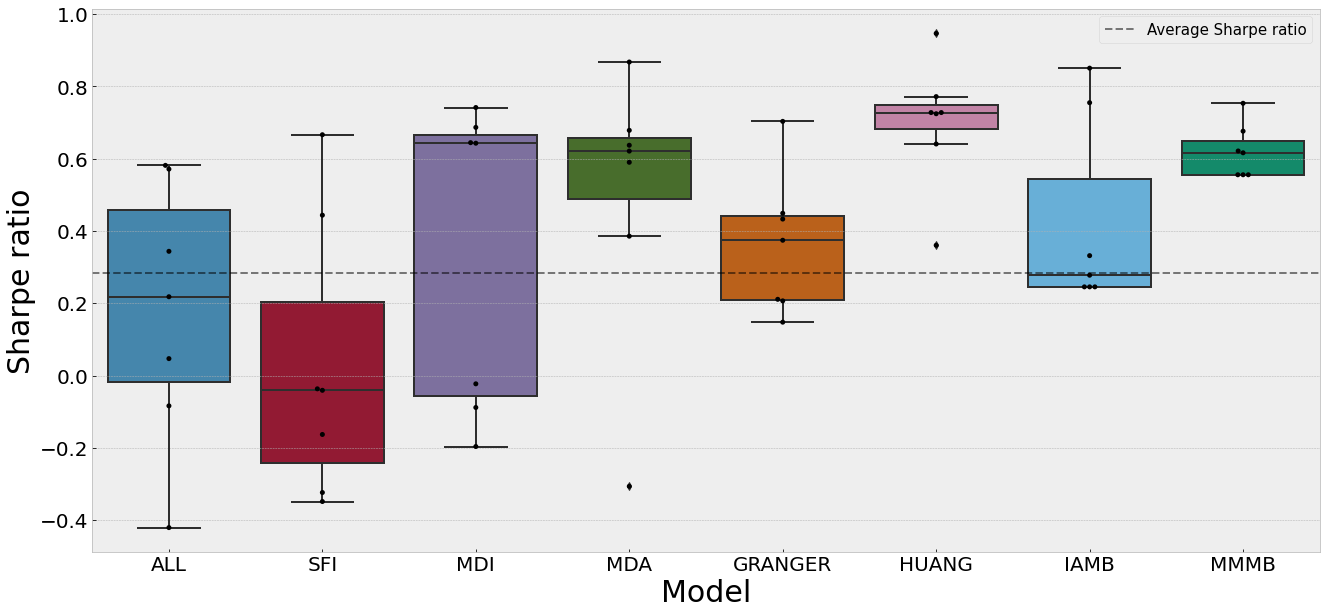

In [29]:
display(Markdown("### 2.5) Out of sample Sharpe ratio distribution across models (SPX Index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='sharpe ratio',data=sr_df_spx, ax=ax, order=fs_methods2);
sns.swarmplot(x="fs", y='sharpe ratio',
              data=sr_df_spx,ax=ax,
              color="k",order=fs_methods2)
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr,
           color='k',
           linestyle='--',
           alpha=0.5, label="Average Sharpe ratio");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_sr_fs_methods_distr_spx.png')

## 3) Cummulative returns

In [33]:
summary_oos_pred_ret_df = oos_pred_ret_df.loc[oos_pred_ret_df['ticker']==ticker]
summary_benchmark_df = benchmark_df.loc[benchmark_df['ticker']==ticker]

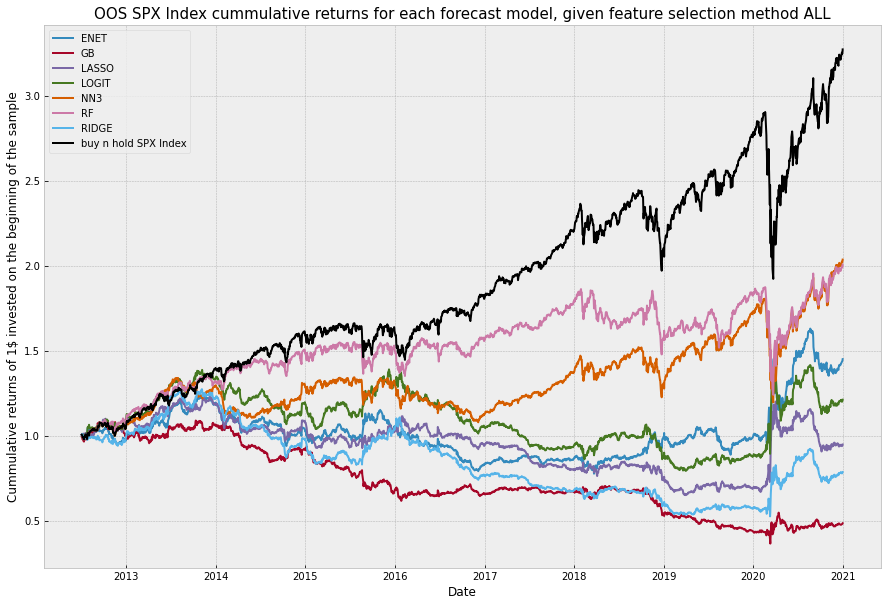

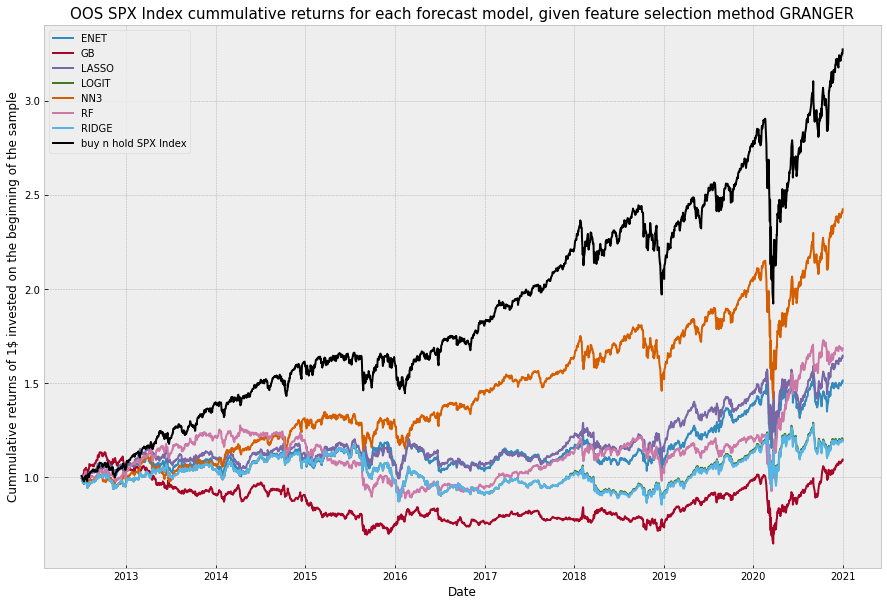

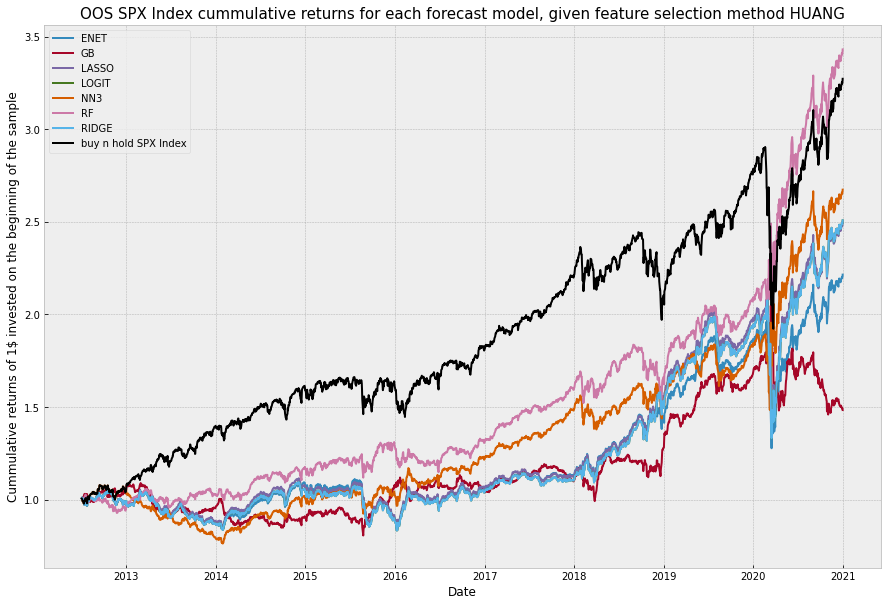

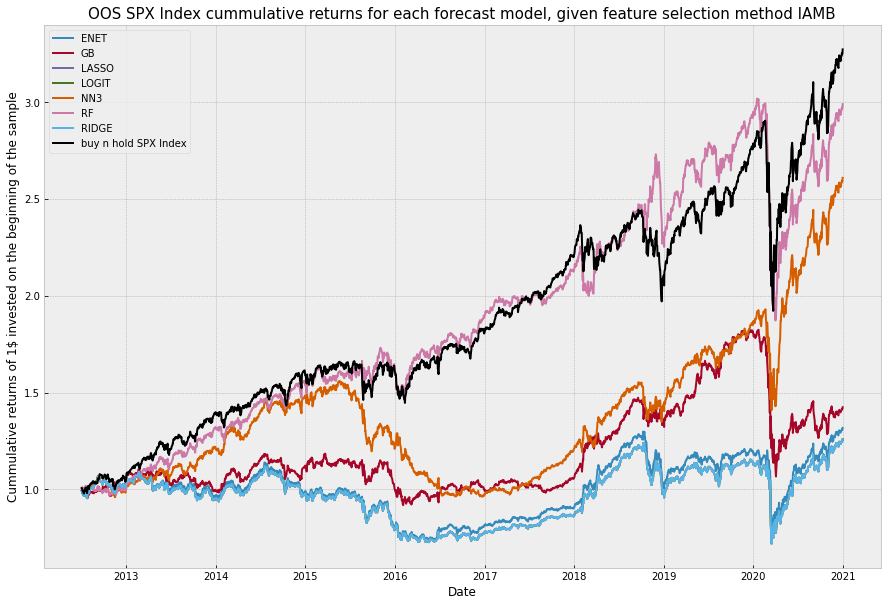

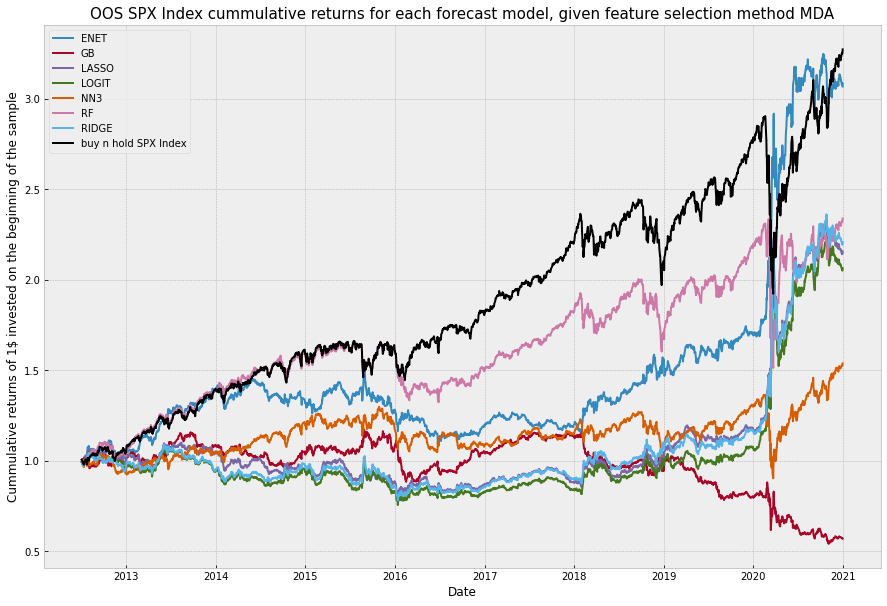

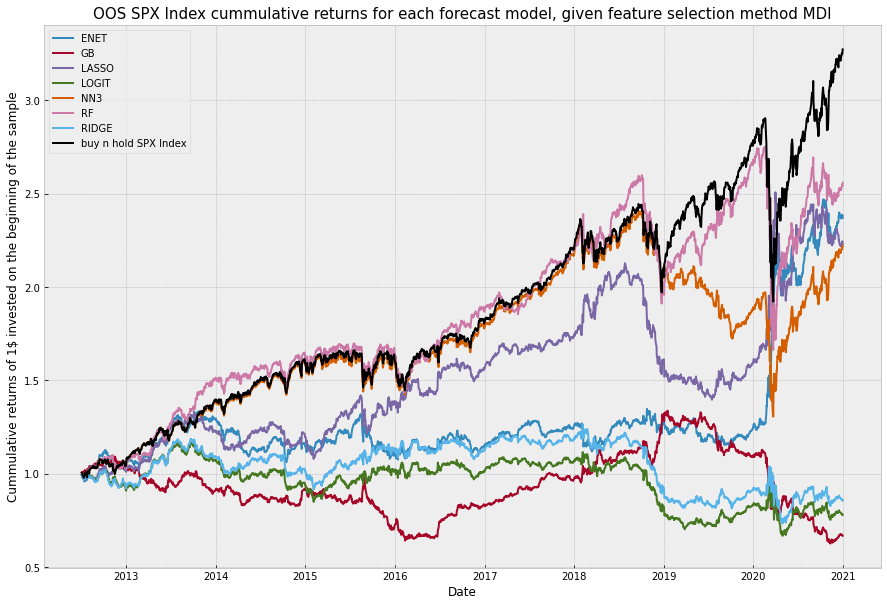

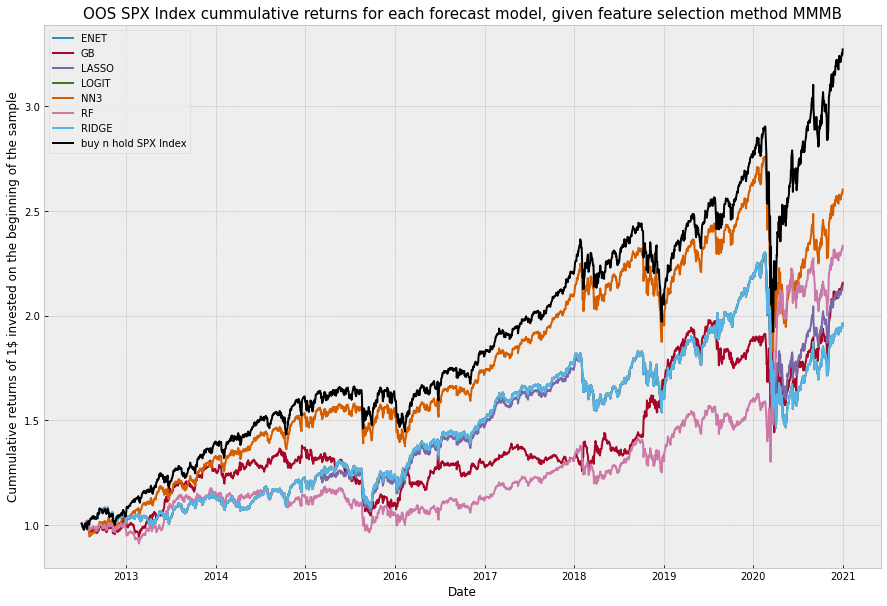

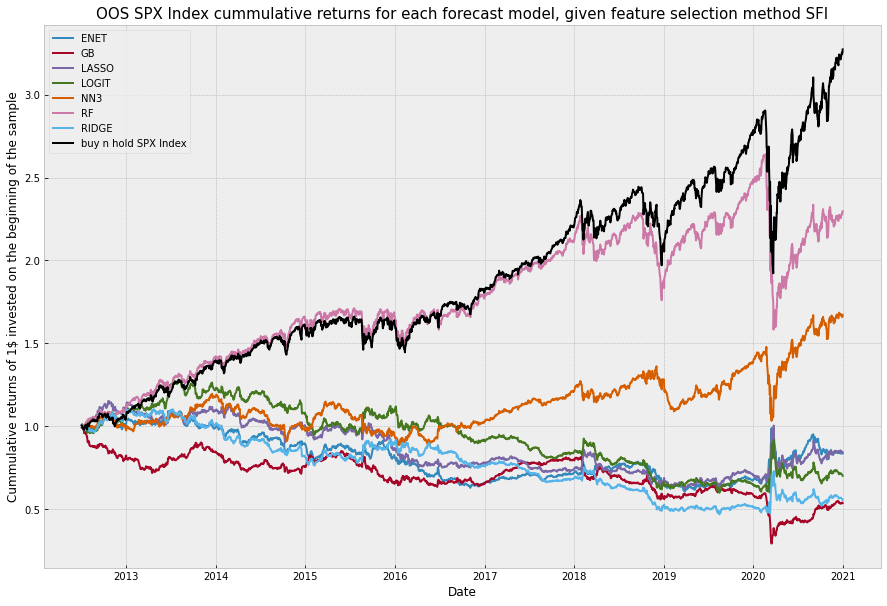

In [34]:
ticker = 'SPX Index'

for key1 in summary_oos_pred_ret_df['fs'].unique():
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(label='OOS ' + ticker + ' cummulative returns for each forecast model, given feature selection method ' + key1, fontsize=15)

    for key2 in summary_oos_pred_ret_df['model'].unique():
        loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['fs'] == key1)&
                                              (summary_oos_pred_ret_df['model'] == key2)&
                                              (summary_oos_pred_ret_df['ticker'] == ticker)]
        ax.plot(pd.to_datetime(loop_df['date']), (1+loop_df['value']/100).cumprod(), label=key2)

    bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']==ticker)&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]
    ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)
    
    plt.xlabel("Date")
    plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
    plt.legend(loc='best', fontsize=10)   
    fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
    plt.show()

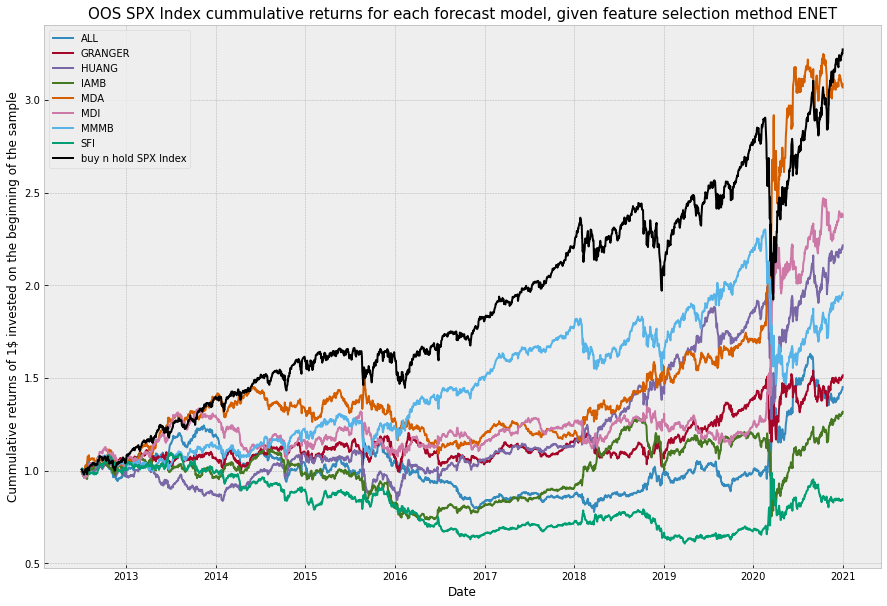

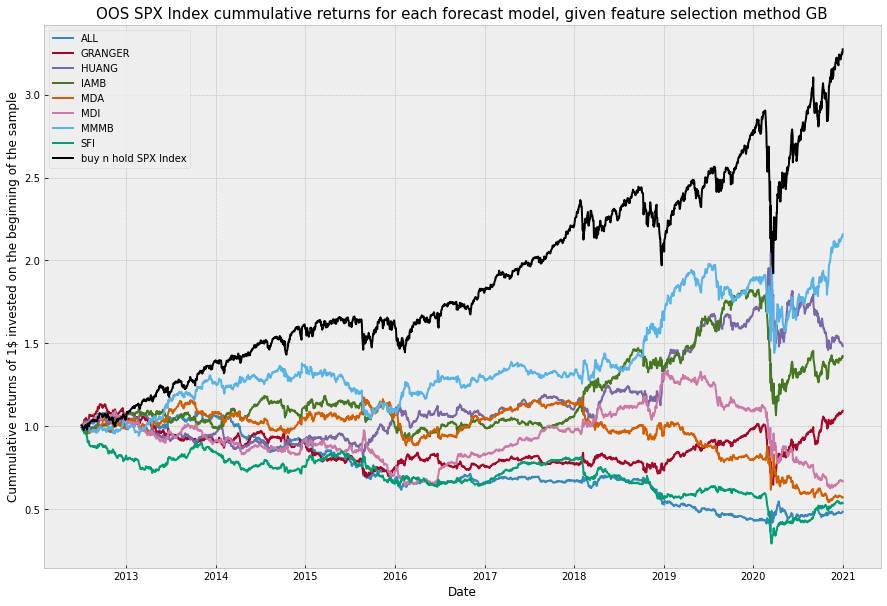

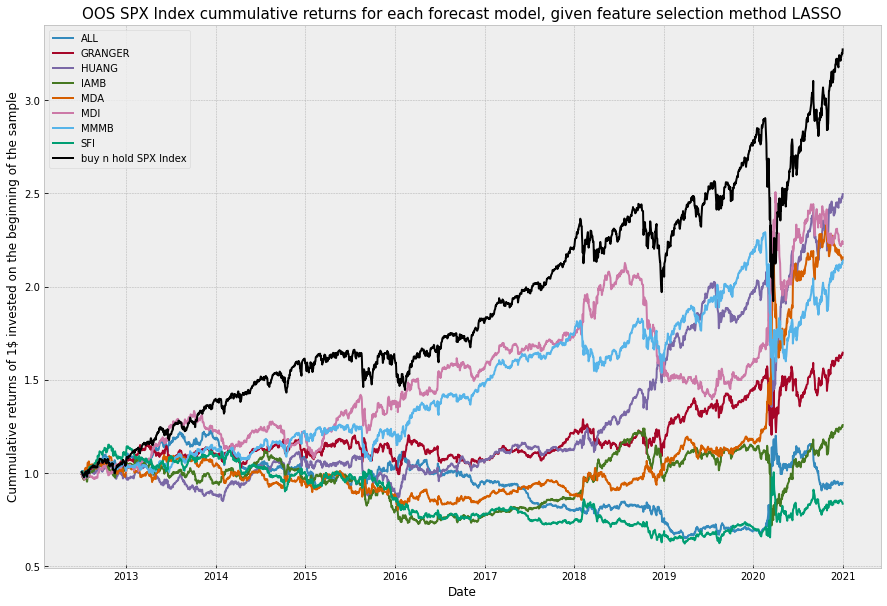

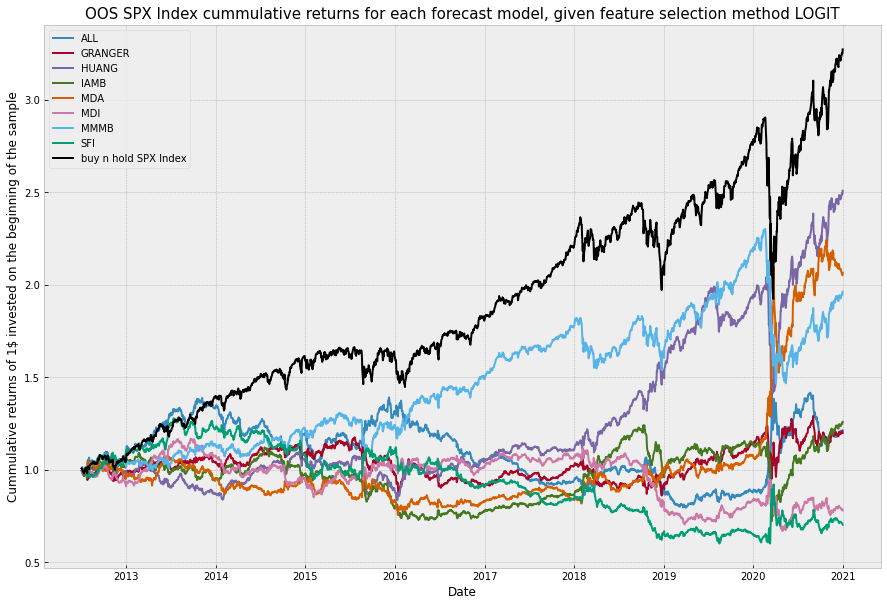

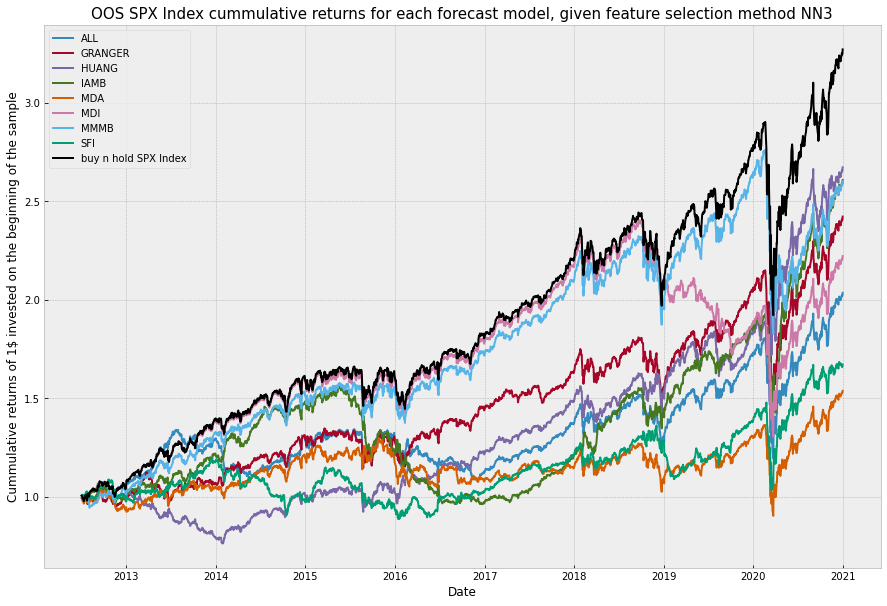

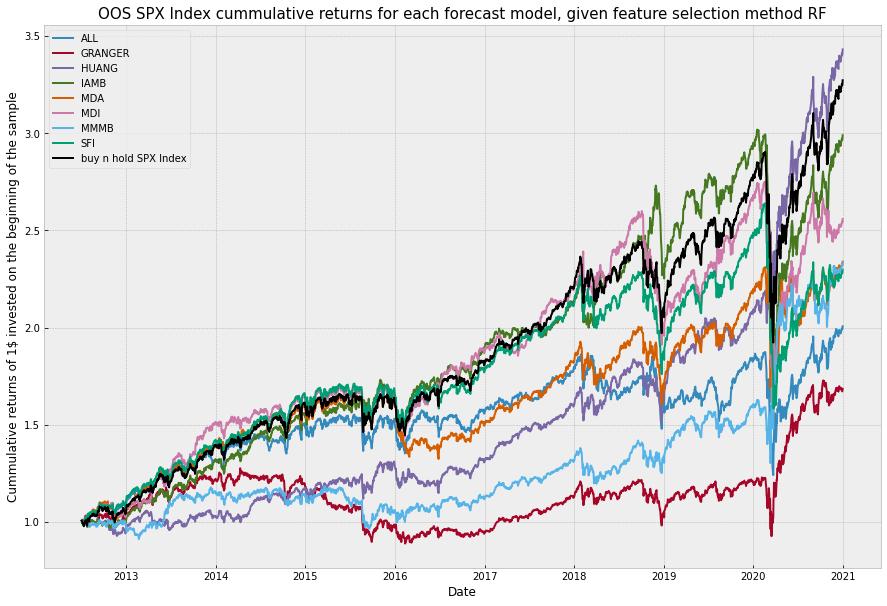

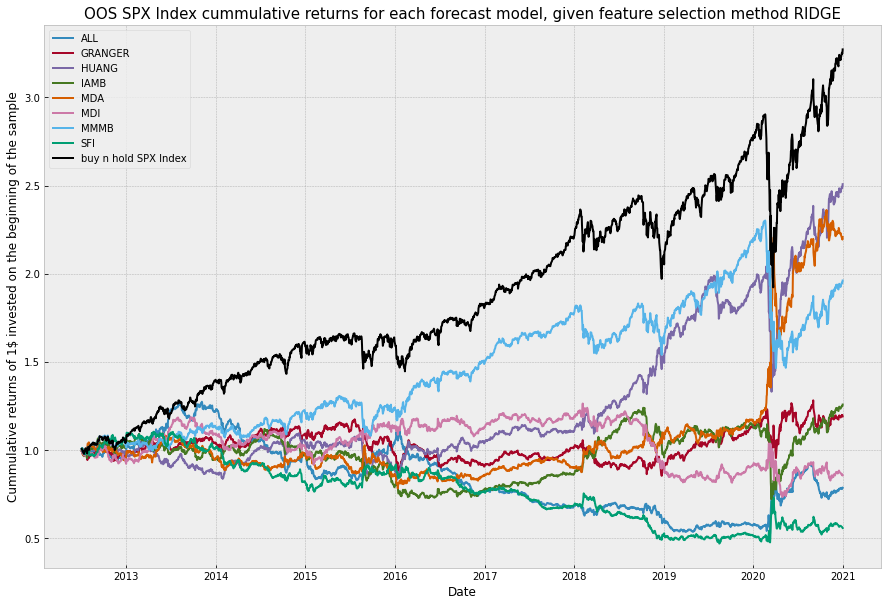

In [35]:
for key1 in summary_oos_pred_ret_df['model'].unique():
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(label='OOS ' + ticker + ' cummulative returns for each forecast model, given feature selection method ' + key1, fontsize=15)

    for key2 in summary_oos_pred_ret_df['fs'].unique():
        loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['model'] == key1)&
                                              (summary_oos_pred_ret_df['fs'] == key2)&
                                              (summary_oos_pred_ret_df['ticker'] == ticker)]
        ax.plot(pd.to_datetime(loop_df['date']), (1+loop_df['value']/100).cumprod(), label=key2)

    bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']==ticker)&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]
    ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)
    
    plt.xlabel("Date")
    plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
    plt.legend(loc='best', fontsize=10)    
    fig.savefig('img/' + ticker + '_' + key1 + '_models.png')
    plt.show()

In [41]:
loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['fs'] == 'HUANG')&
                                          (summary_oos_pred_ret_df['model'] == 'RF')&
                                          (summary_oos_pred_ret_df['ticker'] == 'SPX Index')]
bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']=='SPX Index')&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]

In [55]:
best_df = pd.concat([loop_df.pivot_table(index=['date'], columns=['fs', 'model', 'ticker'], values=['value']),
                     bench.pivot_table(index=['date'], columns=['fs', 'model', 'ticker'], values=['value'])], axis=1)
best_df.columns = ['RF and HUANG predictions', 'Buy-n-hold SPX Index']
best_df['Combination of RF+HUANG and the Buy-n-hold'] = best_df.mean(axis=1)

In [64]:
best_df.mean() / best_df.std() * np.sqrt(252) 

RF and HUANG predictions                      0.946450
Buy-n-hold SPX Index                          0.913600
Combination of RF+HUANG and the Buy-n-hold    0.992983
dtype: float64

In [60]:
best_df.mean(axis=1).mean() / best_df.mean(axis=1).std() * np.sqrt(252)

0.9929829031757417

<AxesSubplot:title={'center':'Cummulative returns for a portfolio with 50%/50% of the RF+HUANG model and the Buy-and-hold'}, xlabel='date'>

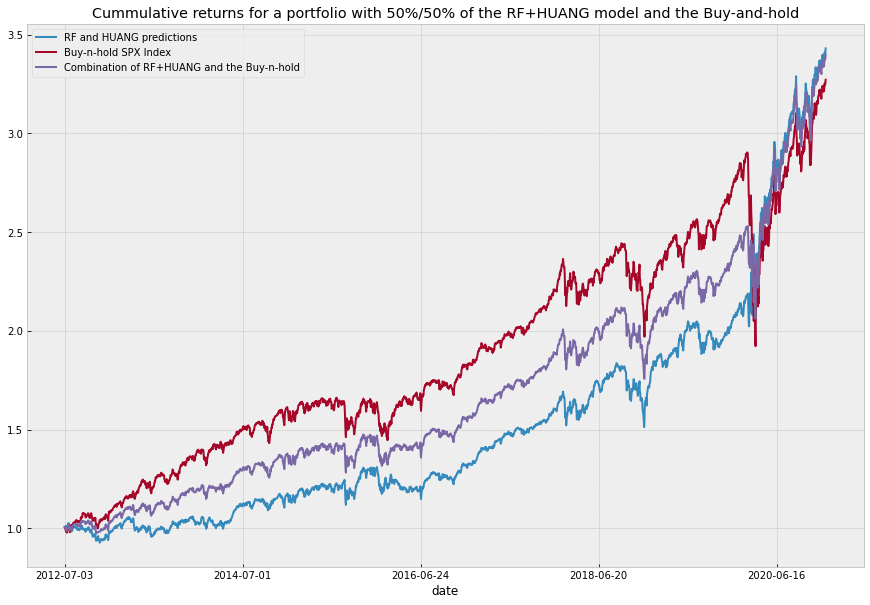

In [62]:
(1+best_df/100).cumprod().plot(figsize=(15, 10), title='Cummulative returns for a portfolio with 50%/50% of the RF+HUANG model and the Buy-and-hold')

In [54]:
ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)

date
2012-07-03    0.6466
2012-07-05   -0.4677
2012-07-06    0.0000
2012-07-09   -0.1627
2012-07-10   -0.8121
               ...  
2020-12-24    0.3615
2020-12-28    0.8723
2020-12-29   -0.2227
2020-12-30    0.1451
2020-12-31    0.6518
Length: 2139, dtype: float64

In [ ]:
tot_time = time() - init
tot_time = tot_time / 60
print("notebook time = {:.3f} (minutes)".format(tot_time))